In [55]:
import numpy as np  # probably don't need to load
import pandas as pd
import datetime as dt
#import pandas_datareader.data as web  # probably don't need to load
#import quandl

#import blpapi
#from xbbg import blp

#import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [10]:
path = 'Z:/Shared/Risk Management and Investment Technology/CLO Optimization/'
file = 'CLO21 model portfolio as of 03.18.21 - With New WARF Logic.xlsm'
filepath= path+file


# Functions

## Key Stat Functions

In [23]:
# this works; spot checked
def moodys_adjusted_warf(df,moodys_score,moodys_rfTable):
    """
    This function creates the new Moody's Ratings Factor based 
    on the old Moody's rating.
    
    Arg in:
        df: the input data frame (from the MASTER table d/l'd from BMS)
        moodys_score: dataframe with alphanumeric rating to numeric map (1 to 1 map; linear)
        moodys_rfTable: dataframe with alphanumeric rating to new WARF numeric (1 to 1 map; 1 to 1000 values)
    """
    score = df['Moodys CFR'].map(dict(moodys_score[['Moodys','Score']].values))
    updown = df['Moodys Issuer Watch'].\
        apply(lambda x: -1 if x == 'Possible Upgrade' else 1 if x == 'Possible Downgrade' else 0)
    aScore = score + updown
    Adjusted_CFR_for_WARF = aScore.map(dict(moodys_score[['Score','Moodys']].values))
    # I keep the same column name as Jeff to make it easier to double check values
    df['Adj. WARF NEW'] = Adjusted_CFR_for_WARF.map(dict(moodys_rfTable[['Moody\'s Rating Factor Table','Unnamed: 10']].values))
    return df

def sp_recovery_rate(model_df,lien,new_rr,bond_table):
    """
    This function get the S&P recovery rate as a percent. If it doesn't exist
    in the master field, it will look up in the appropriate first and second 
    lien tables, if not, will look up the bond table.
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        lien: a DF table with the RR's for first and second lien by country
        new_rr: a df mapping of the old notation for RR to a new RR in percentage
        bond_table: split out of a table for RR for bonds
    Arg out:
        model_df with inserted new column 'S&P Recovery Rate (AAA)'
    """
     
    # if it the Recovery rate exists lookup in AAA table
    model_df['S&P Recovery Rate (AAA)'] = model_df['S&P Recovery'].\
        map(dict(new_rr[['S&P Recovery Rating\nand Recovery\nIndicator of\nCollateral Obligations','“AAA”']].values))
    
    # doesn't exist, but first lien, use first lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'S&P Recovery Rate (AAA)'] =\
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'Issuer Country'].\
        map(dict(lien[['Country Abv','RR']].values))
    
    
    # doesn't exist, but 2nd lien, use 2nd lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'Issuer Country'].\
        map(dict(lien[['Country Abv','RR.2nd']].values))
    
    # the bonds
    model_df.loc[pd.isna(model_df['S&P Recovery']) & pd.isna(model_df['Lien Type']),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_df['S&P Recovery']) & pd.isna(model_df['Lien Type']),'Issuer Country'].\
        map(dict(bond_table[['Country Abv.1','RR.1']].values))

    return model_df

def diversity_score(model_df, ind_avg_eu):
    """
    This function calculates the Moody's Industry Diversity Score for the CLO
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        ind_avg_eu: Moody's discrete lookup table that maps AIEUS to IDS, need to be sorted
    Arg out:
        dscore: the scalar measure of the IDS
    """
    
    #first create the Par amount filtering out defaults
    #model_df['Par_no_default'] = model_df['Total']
    #model_df.loc[model_df['Default']=='Y','Par_no_default'] = 0
    div_df = model_df[['Parent Company','Moodys Industry','Par_no_default']].copy()
    div_df.sort_values(by='Moodys Industry',inplace=True)

    # this keeps the industry, but groups on parent company for multiple loans
    test = div_df.groupby(by=['Parent Company','Moodys Industry']).sum()
    avg_par_amt = test.sum()/test.count()   
    
    # create the EU score for each parent
    # Lesser of 1 and Issuer Par Amount for such issuer divided by the Average Par Amount.
    test['EU'] = test[['Par_no_default']]/test[['Par_no_default']].mean()
    test.loc[test['EU']>1,'EU']=1
    
    # groupby Industry for the Ind Div Score
    IDS = test.groupby(by=['Moodys Industry']).sum()

    # this is like vlookup(..,TRUE) where the nearest match on merge is used, direction controls how
    # backward is the lesser if EU falls between AIEUS marks
    df_merged = pd.merge_asof(IDS.sort_values('EU'), ind_avg_eu, left_on='EU', 
                          right_on='Aggregate\nIndustry\nEquivalent\nUnit Score', direction='backward', suffixes=['', '_2'])
    dscore = df_merged['Industry\nDiversity\nScore'].sum()
    return dscore

def Port_stats(model_df, ind_avg_eu):
    Port_stats_df = pd.DataFrame(np.nan,index=['Min Floating Spread Test - no Libor Floors',
        'Min Floating Spread Test - With Libor Floors',
        'Max Moodys Rating Factor Test (NEW WARF)',
        'Max Moodys Rating Factor Test (Orig WARF)',
        'Min Moodys Recovery Rate Test',
        'Min S&P Recovery Rate Class A-1a',
        'Moodys Diversity Test',
        'WAP',
        'Total Portfolio Par (excl. Defaults)',
        'Total Portfolio Par',
        'Current Portfolio'],columns = ['Portfolio Stats'])

    
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors','Portfolio Stats'] = \
        (model_df['Par_no_default']*model_df['Spread']).sum()/model_df['Par_no_default'].sum()*100
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors','Portfolio Stats'] = \
        (model_df['Par_no_default']*model_df['Adj. All in Rate']).sum()/model_df['Par_no_default'].sum()*100
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)','Portfolio Stats'] = \
        (model_df['Par_no_default']*model_df['Adj. WARF NEW']).sum()/model_df['Par_no_default'].sum()
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)','Portfolio Stats'] = \
        (model_df['Par_no_default']*model_df['WARF']).sum()/model_df['Par_no_default'].sum()
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Min Moodys Recovery Rate Test','Portfolio Stats'] = \
        (model_df['Par_no_default']*model_df['Moodys Recovery Rate']).sum()/model_df['Par_no_default'].sum()*100
    Port_stats_df.loc['Min Moodys Recovery Rate Test'] = \
        Port_stats_df.loc['Min Moodys Recovery Rate Test'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a','Portfolio Stats'] = \
        (model_df['Par_no_default']*model_df['S&P Recovery Rate (AAA)']).sum()/model_df['Par_no_default'].sum()*100
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'] = \
        Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Moodys Diversity Test','Portfolio Stats'] = diversity_score(model_df, ind_avg_eu)
    Port_stats_df.loc['Moodys Diversity Test'] = \
        Port_stats_df.loc['Moodys Diversity Test'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['WAP','Portfolio Stats'] = \
        sum(model_df['Total']*model_df['Blended Price']/sum(model_df['Total']))
    Port_stats_df.loc['WAP'] = \
        Port_stats_df.loc['WAP'].apply('${:.2f}'.format)

    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)','Portfolio Stats'] = model_df['Par_no_default'].sum()
    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'] = \
        Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'].apply('{:,.0f}'.format)

    
    Port_stats_df.loc['Total Portfolio Par','Portfolio Stats'] = model_df['Total'].sum()
    Port_stats_df.loc['Total Portfolio Par'] = \
        Port_stats_df.loc['Total Portfolio Par'].apply('{:,.0f}'.format)
    
    # current portfolio is Quantity + Add'l Amount (manual) TBA later
    Port_stats_df.loc['Current Portfolio','Portfolio Stats'] = model_df[['Addtl Purchase Amt','Current Portfolio']].sum(axis=1).sum()
    Port_stats_df.loc['Current Portfolio'] = \
        Port_stats_df.loc['Current Portfolio'].apply('{:,.0f}'.format)
    
    return Port_stats_df

In [70]:
def Port_stats_delta(model_df, ind_avg_eu):
    Port_stats_df = pd.DataFrame(np.nan,index=['Min Floating Spread Test - no Libor Floors',
        'Min Floating Spread Test - With Libor Floors',
        'Max Moodys Rating Factor Test (NEW WARF)',
        'Max Moodys Rating Factor Test (Orig WARF)',
        'Min Moodys Recovery Rate Test',
        'Min S&P Recovery Rate Class A-1a',
        'Moodys Diversity Test',
        'WAP',
        'Total Portfolio Par (excl. Defaults)',
        'Total Portfolio Par',
        'Current Portfolio'],columns = ['Portfolio Stats'])

    
    
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Spread']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Adj. All in Rate']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Adj. WARF NEW']).sum()/model_df['Par_no_default_now'].sum()
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['WARF']).sum()/model_df['Par_no_default_now'].sum()
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Min Moodys Recovery Rate Test','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Moodys Recovery Rate']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min Moodys Recovery Rate Test'] = \
        Port_stats_df.loc['Min Moodys Recovery Rate Test'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['S&P Recovery Rate (AAA)']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'] = \
        Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Moodys Diversity Test','Portfolio Stats'] = diversity_score(model_df, ind_avg_eu)
    Port_stats_df.loc['Moodys Diversity Test'] = \
        Port_stats_df.loc['Moodys Diversity Test'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['WAP','Portfolio Stats'] = \
        sum(model_df['Now']*model_df['Blended Price no Trades']/sum(model_df['Now']))
    Port_stats_df.loc['WAP'] = \
        Port_stats_df.loc['WAP'].apply('${:.2f}'.format)

    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)','Portfolio Stats'] = model_df['Par_no_default_now'].sum()
    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'] = \
        Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'].apply('{:,.0f}'.format)

    
    Port_stats_df.loc['Total Portfolio Par','Portfolio Stats'] = model_df['Now'].sum()
    Port_stats_df.loc['Total Portfolio Par'] = \
        Port_stats_df.loc['Total Portfolio Par'].apply('{:,.0f}'.format)
    
    # current portfolio is Quantity + Add'l Amount (manual) TBA later
    Port_stats_df.loc['Current Portfolio','Portfolio Stats'] = model_df[['Addtl Purchase Amt','Current Portfolio']].sum(axis=1).sum()
    Port_stats_df.loc['Current Portfolio'] = \
        Port_stats_df.loc['Current Portfolio'].apply('{:,.0f}'.format)
    
    return Port_stats_df

In [24]:
def replines(model_df):
    replines = model_df[model_df['Issuer'].str.match('zz_LXREP')]
    repline_stats_df = pd.DataFrame(np.nan,index=['Amount',
        'WAS',
        'WAPP',
        'WARF New',
        'WARF Orig'],columns = ['Repline Stats'])
    pot_trades = replines['Potential Trades']
    repline_stats_df.loc['Amount','Repline Stats'] = pot_trades.sum()/1000000
    repline_stats_df.loc['WAS','Repline Stats'] = (pot_trades*replines['Spread']).sum()/pot_trades.sum()*100
    repline_stats_df.loc['WAPP','Repline Stats'] = (pot_trades*replines['Ask']).sum()/pot_trades.sum()
    repline_stats_df.loc['WARF New','Repline Stats'] = (pot_trades*replines['Adj. WARF NEW']).sum()/pot_trades.sum()
    repline_stats_df.loc['WARF Orig','Repline Stats'] = (pot_trades*replines['WARF']).sum()/pot_trades.sum()
    
    # just formatting
    repline_stats_df.loc['Amount'] = repline_stats_df.loc['Amount'].apply('${:.1f}'.format)
    repline_stats_df.loc['WAS'] = repline_stats_df.loc['WAS'].apply('{:.2f}%'.format)
    repline_stats_df.loc['WAPP'] = repline_stats_df.loc['WAPP'].apply('{:.2f}'.format)
    repline_stats_df.loc['WARF New'] = repline_stats_df.loc['WARF New'].apply('{:.0f}'.format)
    repline_stats_df.loc['WARF Orig'] = repline_stats_df.loc['WARF Orig'].apply('{:.0f}'.format)
    
    return repline_stats_df


## Simple IO Functions for reading tables from Excel

In [25]:
# functions for reading the relevant spreadsheet data
# I am making them simple and separated so they can be replaced
# by other bespoke solutions like direct APIs from the source,
# also aides readability and debugging

def get_master_df(filepath,sheet='MASTER'):
    master_df = pd.read_excel(filepath,sheet_name=sheet,header=1)
    master_df = master_df.loc[:,~master_df.columns.str.match("Unnamed")]
    master_df.rename(columns={'LoanX ID':'LXID'},inplace=True)
    master_df.set_index('LXID', inplace=True)
    return master_df

def get_CLO_df(filepath,sheet='CLO 21 Port as of 3.18'):
    CLO_df = pd.read_excel(filepath,sheet_name=sheet,header=6,usecols='A:K')
    CLO_df.dropna(inplace=True)
    CLO_df.rename(columns={'Cusip or LIN':'LXID'},inplace=True)
    CLO_df.set_index('LXID', inplace=True)
    
    # these comments are here, because this is what I used to check
    # his pivot table columns M:0
    # CLO_df[['Cusip or LIN','Quantity','/Unit']].sort_values(by='.Cusip or LIN')
    # CLO_df[['Quantity']].sum()  # verified sum of Quantity
    # CLO_df[['/Unit']].mean()    # verified for average /Unit
    return CLO_df

def get_bidask_df(filepath,sheet='Bid.Ask 3.18'):
    bidask_df = pd.read_excel(filepath,sheet_name=sheet,header=0)
    bidask_df = bidask_df.loc[:,~bidask_df.columns.str.match("Unnamed")]
    bidask_df.set_index('LXID', inplace=True)
    return bidask_df

def get_moodys_rating2rf_tables(filepath,sheet='New WARF'):
    moodys_score = pd.read_excel(filepath,sheet_name=sheet,header=0,usecols='E:F')
    moodys_rfTable = pd.read_excel(filepath,sheet_name=sheet,header=0,usecols='J:K')
    return moodys_score, moodys_rfTable

def get_recovery_rate_tables(filepath,sheet='SP RR Updated'):
    new_sp_rr = pd.read_excel(filepath, sheet_name=sheet, header=1, usecols='L:M')
    new_sp_rr.dropna(how='all',inplace=True)

    lien_rr = pd.read_excel(filepath, sheet_name=sheet, header=1, usecols='A:I')
    lien_rr.dropna(how='all',inplace=True)

    bond_split = lien_rr[lien_rr['Country.1']=='Bonds'].index.values[0]
    bond_table = lien_rr.loc[bond_split+1:]
    lien_rr = lien_rr.loc[:bond_split-1]
    lien_rr.drop(columns=['Unnamed: 4','Country Abv.1','Country.1','Group.1'],inplace=True)
    lien_rr.rename(columns={'RR.1':'RR.2nd'},inplace=True)
    
    return new_sp_rr, lien_rr, bond_table

def get_ind_avg_eu_table(filepath,sheet='Diversity'):
    ind_avg_eu = pd.read_excel(filepath, sheet_name=sheet, header=8, usecols='K:L')
    ind_avg_eu.dropna(how='all',inplace=True)
    return ind_avg_eu

def get_pot_trades(filepath,sheet='Model Portfolio'):
    pot_trades = pd.read_excel(filepath,sheet_name=sheet,header=16,usecols='C:G')
    pot_trades.rename(columns={'LX ID':'LXID'},inplace=True)
    pot_trades.set_index('LXID', inplace=True)

    return pot_trades

## Function for adding in Pricing Fields
(need to expound to all posible purchases)
- now with the functions split out, let's add fields for all in the sub-functions

In [67]:
def BAPP(model_df):
    model_df['Blended Actual Purchase Prices'] = \
        model_df[['Addtl Purchase Amt','Purch Price of Addtl Purch',
                    'Current Portfolio','Actual Purch Price of Current Positions']].\
        apply(lambda x: 100*((x[0]*x[1]/100)+(x[2]*x[3]/100))/(x[0]+x[2]),axis=1)
    model_df.loc[model_df['Blended Actual Purchase Prices'].isna(),'Blended Actual Purchase Prices'] = 0
    return model_df

def blended_price(model_df):
    model_df['Blended Price'] = model_df[['Potential Trades',
            'Addtl Purchase Amt','Blended Actual Purchase Prices','Total','Bid','Ask','Current Portfolio']].\
            apply(lambda x: ((x[0]*x[4]/100+(x[6]+x[1])*x[2])/x[3])*100 if x[0]<1 else \
                            ((x[0]*x[5]/100+(x[6]+x[1])*x[2])/x[3])*100,axis=1 )
    model_df.loc[model_df['Blended Price'].isna(),'Blended Price'] = 0
    return model_df

def par_build_loss(model_df,pot_trades='Potential Trades'):
    model_df['Par_Build_Loss_Sale'] = model_df[[pot_trades,
                                                    'Bid','Actual Purch Price of Current Positions']].\
            apply(lambda x: ((-x[0]*x[1]/100)-(-x[0]*x[2]/100) if x[0]<0 else 0),axis=1)
    model_df['Par_Build_Loss_Buy'] = model_df[[pot_trades,'Ask']].\
            apply(lambda x: ((-x[0]*x[1]/100)+x[0]) if x[0]>0 else 0,axis=1)
    model_df['Total_Par_Build_Loss'] = model_df[['Par_Build_Loss_Sale','Par_Build_Loss_Buy']].sum(axis=1)
    return model_df

def mil_par_build_loss(model_df,pot_trade_size=1000000):
    """
    This function calculates the Par B/L Sale, Buy and Total for ALL
    loans assuming 1mn notional (optional change size).  Essentially,
    consider this akin to Marginal Contribution to Par B/L
    
    Arg in:
        model_df
        pot_trade_size (default=100000)
    Arg out:
        model_df with additional columns, Mil_Par_BL_Sale, Mil_Par_BL_Buy, Mil_Par_Build_Loss
    """
    trade = -pot_trade_size
    model_df['Mil_Par_BL_Sale'] = model_df[['Bid','Actual Purch Price of Current Positions']].\
            apply(lambda x: ((-trade*x[0]/100)-(-trade*x[1]/100)),axis=1)
    trade = pot_trade_size
    model_df['Mil_Par_BL_Buy'] = model_df[['Ask']].\
            apply(lambda x: ((-trade*x/100)+trade),axis=1)
    model_df['Mil_Par_Build_Loss'] = model_df[['Mil_Par_BL_Sale','Mil_Par_BL_Buy']].sum(axis=1)
    return model_df

def model_pricing(model_df):
    model_df.loc[model_df['Close Offer'].isna(),'Close Offer'] = 99
    model_df.loc[model_df['Issuer'].str.match('zz_LXREP'),'Close Offer'] = 99.5
    model_df.loc[model_df['Issuer'].str.match('zz_LXREP03'),'Close Offer'] = 99
    model_df.loc[model_df['Issuer'].str.match('zz_LXREP12'),'Close Offer'] = 99
    model_df.loc[model_df['Close Bid'].isna(),'Close Bid'] = 99
    model_df.loc[model_df['/Unit'].isna(),'/Unit'] = 0
    model_df.rename(columns={'Close Offer':'Ask','Close Bid':'Bid',
                               '/Unit':'Actual Purch Price of Current Positions'},inplace=True)
    model_df.loc[model_df['Actual Purch Price of Current Positions'].isna(),'Actual Purch Price of Current Positions'] = 0
    model_df['Current Portfolio'] = model_df['Quantity']
    model_df.loc[model_df['Current Portfolio'].isna(),'Current Portfolio'] = 0
    model_df.loc[model_df['Potential Trades'].isna(),
               'Potential Trades'] = 0
    model_df.loc[model_df['Addtl Purchase Amt'].isna(),'Addtl Purchase Amt'] = 0
    model_df.loc[model_df['Purch Price of Addtl Purch'].isna(),'Purch Price of Addtl Purch'] = 0

    model_df['Total'] = model_df[['Current Portfolio',
                                      'Addtl Purchase Amt',
                                      'Potential Trades']].sum(axis=1)
    model_df['Now'] = model_df[['Current Portfolio',
                                      'Addtl Purchase Amt']].sum(axis=1)
    
    #create the Blended Actual Purchase Price field
    model_df = BAPP(model_df)

    #create the Blended Price field
    model_df = blended_price(model_df)

    # create the Par Build and Loss fields
    model_df = par_build_loss(model_df)
    
    model_df['Par_no_default'] = model_df['Total'].values
    model_df.loc[model_df['Default']=='Y','Par_no_default'] = 0

    model_df['Par_no_default_now'] = model_df['Now'].values
    model_df.loc[model_df['Default']=='Y','Par_no_default_now'] = 0
    
    return model_df

## Main function for creating Model Portfolio dataframe

In [45]:
def create_model_port_df(filepath):
    
    # first read in all relevant tables from the CLO model sprdsht
    master_df = get_master_df(filepath,sheet='MASTER')
    CLO_df = get_CLO_df(filepath,sheet='CLO 21 Port as of 3.18')
    bidask_df = get_bidask_df(filepath,sheet='Bid.Ask 3.18')
    moodys_score, moodys_rfTable = get_moodys_rating2rf_tables(filepath,sheet='New WARF')
    new_sp_rr, lien_rr, bond_table = get_recovery_rate_tables(filepath,sheet='SP RR Updated')
    ind_avg_eu = get_ind_avg_eu_table(filepath,sheet='Diversity')
    pot_trades = get_pot_trades(filepath,sheet='Model Portfolio')
    
      
    # merge MASTER + CLO + Bid.Ask + Potential Trades
    model_port = master_df.merge(CLO_df,left_on="LXID",right_on="LXID",how='outer') 
    model_port = model_port.merge(bidask_df,left_on="LXID",right_on="LXID",how='left')
    model_port = model_port.merge(pot_trades, left_on='LXID', right_on='LXID',how='outer')
    model_port.columns = model_port.columns.str.replace('\'','')
    
    # Here is where I think I should add subsetting for needed fields & renaming
    to_rename = {'Potential Trades\nBuys as Positives\nSales as (Negative)':'Potential Trades',
                 'Floating Spread':'Spread',
                 'Floating Spread Floor':'Floor'}
    
    model_port.rename(columns=to_rename,inplace=True)
    
    # add in metric like New WARF, SP's RR, Par no Default, Adj All in Rate
    model_port = moodys_adjusted_warf(model_port,moodys_score,moodys_rfTable)
    model_port = sp_recovery_rate(model_port,lien_rr,new_sp_rr,bond_table)
    
    # need a way to pass LIBOR
    libor = 0.002
    model_port['Adj. All in Rate'] = model_port[['Spread','Floor']].\
        apply(lambda x: (x[0]+x[1]-libor) if (x[1]>libor) else x[0],axis=1 )
    
    #add in all the Pricing stats
    model_port = model_pricing(model_port)
    
    return model_port, ind_avg_eu

# Create Model Portfolio Dataframe

In [53]:
model_port, ind_avg_eu = create_model_port_df(filepath)


<ipython-input-52-aca0a0007869>:5: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda x: 100*((x[0]*x[1]/100)+(x[2]*x[3]/100))/(x[0]+x[2]),axis=1)
<ipython-input-52-aca0a0007869>:12: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda x: ((x[0]*x[4]/100+(x[6]+x[1])*x[2])/x[3])*100 if x[0]<1 else \


In [54]:
model_port.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497 entries, LX190245 to LXREP26
Data columns (total 90 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Combined                                 497 non-null    object        
 1   Parent Company                           497 non-null    object        
 2   Issuer                                   497 non-null    object        
 3   Asset                                    497 non-null    object        
 4   Analyst                                  463 non-null    object        
 5   Spread                                   489 non-null    float64       
 6   Floor                                    474 non-null    float64       
 7   All In Rate                              471 non-null    float64       
 8   Maturity Date                            495 non-null    datetime64[ns]
 9   Mark Price                           

In [60]:
libor = 0.002
model_port[['Spread','Floor']].\
        apply(lambda x: (x[0]+x[1]-libor) if (x[1]>libor) else x[0],axis=1 )

LXID
LX190245        0.0730
LX190219        0.0430
LX182732        0.0125
USC6900PAL34       NaN
LX183929        0.0175
                 ...  
LXREP22         0.0480
LXREP23         0.0450
LXREP24         0.0505
LXREP25         0.0530
LXREP26         0.0780
Length: 497, dtype: float64

In [68]:
mil_par_build_loss(model_port).info()

<class 'pandas.core.frame.DataFrame'>
Index: 497 entries, LX190245 to LXREP26
Data columns (total 93 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Combined                                 497 non-null    object        
 1   Parent Company                           497 non-null    object        
 2   Issuer                                   497 non-null    object        
 3   Asset                                    497 non-null    object        
 4   Analyst                                  463 non-null    object        
 5   Spread                                   489 non-null    float64       
 6   Floor                                    474 non-null    float64       
 7   All In Rate                              471 non-null    float64       
 8   Maturity Date                            495 non-null    datetime64[ns]
 9   Mark Price                           

# Model Portfolio stats
- Estimated Libor
- Minimum Floating Spread Test - Without Libor Floors
- Minimum Floating Spread Test - WithLibor Floors (adj. All in Rate)
- Maximum Moody's Rating Factor Test
- Maximum Moody's Rating Factor Test (NEW WARF)
- Maximum Moody's Rating Factor Test (Orig WARF)
- Minimum Weighted Average Moody's Recovery Rate Test
- Minimum Weighted Average S&P Recovery Rate Class A-1a
- Moody's Diversity Test
- WAP (Current Positions use Actual purchase price, all others use Ask price)
- Total Portfolio Par (excluding Defaults)
- Total Portfolio Par
- Current Portfolio 

- To potentially add:
- WAL (for test)
- Overcollateralization (for test)
- 

In [57]:
Port_stats(model_port,ind_avg_eu)

,Portfolio Stats
Min Floating Spread Test - no Libor Floors,3.31%
Min Floating Spread Test - With Libor Floors,3.56%
Max Moodys Rating Factor Test (NEW WARF),2726
Max Moodys Rating Factor Test (Orig WARF),2816
Min Moodys Recovery Rate Test,47.8%
Min S&P Recovery Rate Class A-1a,42.2%
Moodys Diversity Test,80
WAP,$99.70
Total Portfolio Par (excl. Defaults),"400,000,000"
Total Portfolio Par,"400,000,000"


In [71]:
Port_stats_delta(model_port, ind_avg_eu)

KeyError: 'Par_no_default_now'

In [58]:
replines(model_port)

,Repline Stats
Amount,$79.2
WAS,3.80%
WAPP,99.46
WARF New,3022
WARF Orig,2954


# Optimization/Screening

- goals = higher spread

types of queries?

- how do I raise my WAS by 5 bps and not burn more than 2mm in par

- how to I lower my WARF score without losing spread, or buring par, but willing to sacrifice other things?

- how can I raise my spread but not go above 3200 on WAF, or below 50 on diversity score?

liquidity  everything gets a 1 for now  buy score, and sell score 
internal rating we have this
upside/downside ratio = f(recovery)  - 2nd order


1000 in universe

250 that trade every day (1,1)
200 that they 1 once a week  (2,2)
never see  (5,5)

lon xyz use to (5,2)


In [44]:
# grab the current portfolio stats from above and create a splice where "spread"> current WAS

model_port[['Spread','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Par_no_default']].sort_values(by='Spread',ascending=False)

,Spread,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Par_no_default
LXID,,,,,,
LX187441,0.1100,0.0,3490.0,"Constellis Holdings, LLC",Aerospace & Defense,0.0
LX169474,0.0950,0.0,2720.0,"Research Now Group, Inc.",Services: Business,0.0
LX192625,0.0925,0.0,3490.0,Dynacast (Form Technologies),Capital Equipment,0.0
LX181831,0.0825,0.0,4770.0,MyEyeDr,Retail Stores,0.0
LX191924,0.0775,0.0,3490.0,ICP Group Holdings,"Chemicals, Plastics, & Rubber",0.0
...,...,...,...,...,...,...
USU17185AG14,NaN,0.0,3490.0,CITGO Petroleum Corporation,Energy: Oil & Gas,0.0
USU2089PAE17,NaN,0.0,2720.0,"Consolidated Communications, Inc.",Telecommunications,0.0
USL2969BAA54,NaN,0.0,3490.0,Endo Pharmaceuticals,Healthcare & Pharmaceuticals,0.0


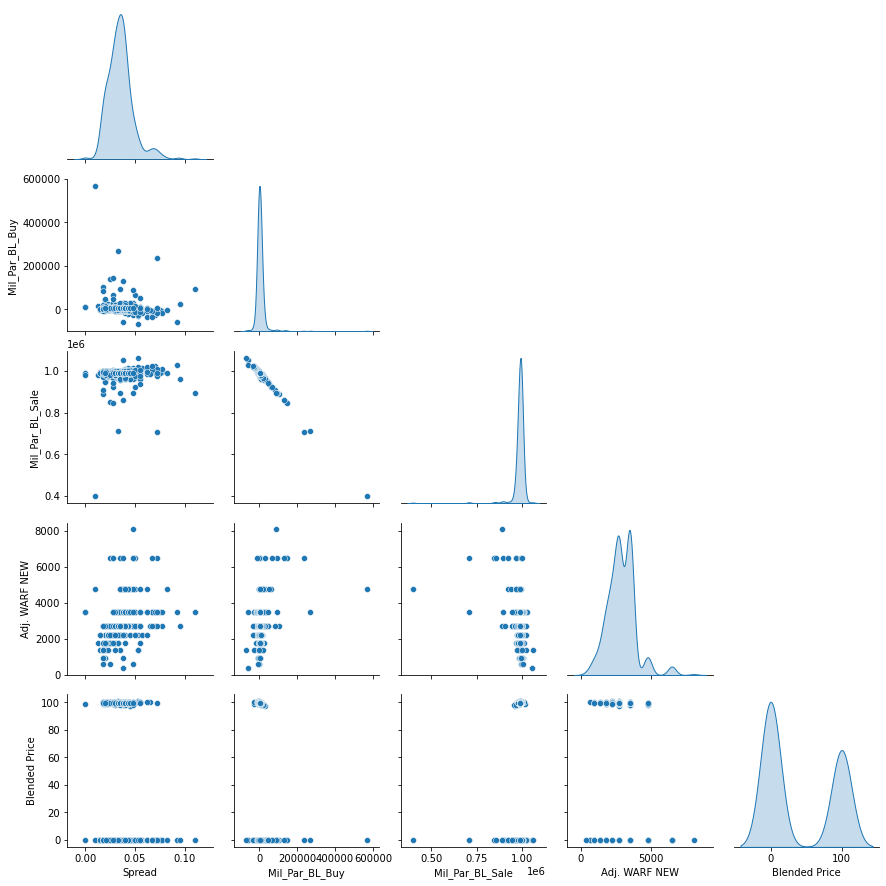

In [69]:
sns_plot = sns.pairplot(model_port[['Spread','Mil_Par_BL_Buy','Mil_Par_BL_Sale',
                                    'Adj. WARF NEW','Blended Price']], diag_kind="kde",corner = True)  #, diag_kind='kde'
fig = sns_plot.fig
fig.savefig(path + "CLO_feature_PairPlot.png")

## constraints/tests

- WARF test
- diversity test
- Over-Collateralization test 
- par burn/build
- Interest Coverage Ratio: Ratio of total interest income generated by the underlying pool of assets to the total interest due on the debt (tranches) outstanding.

- weighted average life test - S&P Weighted Average Life”: On any date of determination, a number calculated 
by determining the number of years between the current date and the maturity date of each USActive 55321025.6 S-8-3 
Collateral Obligation (with an S&P Rating of “CCC-” or higher), multiplying each Collateral 
Obligation’s principal balance by its number of years, summing the results of all Collateral 
Obligations in the portfolio, and dividing such amount by the aggregate principal balance of all 
Collateral Obligations (with an S&P Rating of “CCC-” or higher). 

- recovery rate test
- CCC percentage

- security level attributes

- spread
- (WA)rf
- market price / purchase if own it
- maturity
- rating


- calculate the marginal diversity


In [30]:
# this works
def percentage_C(model_df):  
    return model_df.loc[model_df['Adjusted CFR for WARF'].str.match('C'),['Total']].sum()/model_df[['Total']].sum()

# this has NaT's for some reason, also not likely what is used in WAL test
def WAL(model_df):  
    wal = (model_df['Par_no_default']*(model_df['Maturity']-pd.Timestamp.today())).sum()/model_df['Par_no_default'].sum()*100
    return wal

#def OC_test():
#    return

#def IC_test():
#    return

In [34]:
model_port[['Maturity']].info()
#model_port['Maturity']-pd.Timestamp.today()
WAL(model_port)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 496
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Maturity  456 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 23.9 KB


C:\Users\jknechtel\Miniconda3\lib\site-packages\pandas\core\arrays\timedeltas.py:507: RuntimeWarning: invalid value encountered in multiply
  result = self._data * other


Timedelta('0 days 00:00:00')

## Possible Liquidity Measures
- Equity like measures of liquidity (Low Freq-daily)
- Corwin and Schultz (Journal of Finance 2012) high-low ratio, daily
- Hasbrouck (Journal of Finance 2009)  Gibbs estimator
- Roll (Journal of Finance 1984) covariance spread

- Trader's scores we discussed

# Extra Stuff, Testing


In [ ]:
def blended_price_ex_trade(model_df):
    '''
    Blended Price without Potential Trades
    this is non-sense
    '''
    model_df['Blended Price ex Trades'] = model_df[['Potential Trades',
            'Addtl Purchase Amt','Blended Actual Purchase Prices','Total','Bid','Ask','Current Portfolio']].\
            apply(lambda x: (((x[6]+x[1])*x[2])/x[3])*100,axis=1 )
    model_df.loc[model_df['Blended Price ex Trades'].isna(),'Blended Price ex Trades'] = 0
    return model_df
